# 准备工作

In [1]:
import dnois
import lightning  #noqa
import matplotlib.pyplot as plt
import torch
import torchvision

from viflo.specification import parse_spec_file

In [2]:
torch.set_grad_enabled(False)
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 光学系统分析
## 创建光学系统模型

In [3]:
design_file_path = 'design-files/local-telescope/telescope.py'
specification = parse_spec_file(design_file_path)
specification.setup_global()

In [4]:
framework = specification.create_framework()
framework.to(dev)

model = framework.model
o = model.o

In [5]:
model.c

Camera(
  (optics): CoaxialRayTracing(
    (surfaces): CoaxialSurfaceSequence(
      (0): Conic(
        material=air, reflective=True,
        roc=-4400mm,
        conic=-1.124
        (aperture): AnnularAperture(R1=120mm, R2=440mm)
        (context): CoaxialContext(distance=-1480.21mm)
      )
      (1): Conic(
        material=air, reflective=True,
        roc=-2239mm,
        conic=-5.883
        (aperture): CircularAperture(radius=147mm)
        (context): CoaxialContext(distance=1841.3mm)
      )
      (2): AsphericalRadialPhase(
        material=NHG:IRG207, reflective=False,
        roc=46.6005mm,
        conic=-0.787279,
        a1=0,a2=3.23988e-08,a3=-1.29361e-09,a4=-3.65969e-13,a5=-2.27377e-16,
        norm_radius=50,
        b1=-145.052,b2=-276.625,b3=-184.33
        (aperture): CircularAperture(radius=32.1617mm)
        (context): CoaxialContext(distance=8.29867mm)
      )
      (3): EvenAspherical(
        material=air, reflective=False,
        roc=54.5982mm,
        coni

## 系统特征

In [6]:
def lfmt(x):
    return dnois.Length.fmt(x.item(), 'mm')


# entr_pupil_r, entr_pupil_z = o.entr_pupil()
# exit_pupil_r, exit_pupil_z = o.exit_pupil()
fl = o.focal_length2('trace')
# 以下均默认为中心波长的值
# print(f'Entrance pupil: radius={lfmt(entr_pupil_r)}, z={lfmt(entr_pupil_z)}')
# print(f'Exit pupil: radius={lfmt(exit_pupil_r)}, z={lfmt(exit_pupil_z)}')
print(f'Focal length: {lfmt(fl)}')

Focal length: 3501.4mm


## 光路可视化

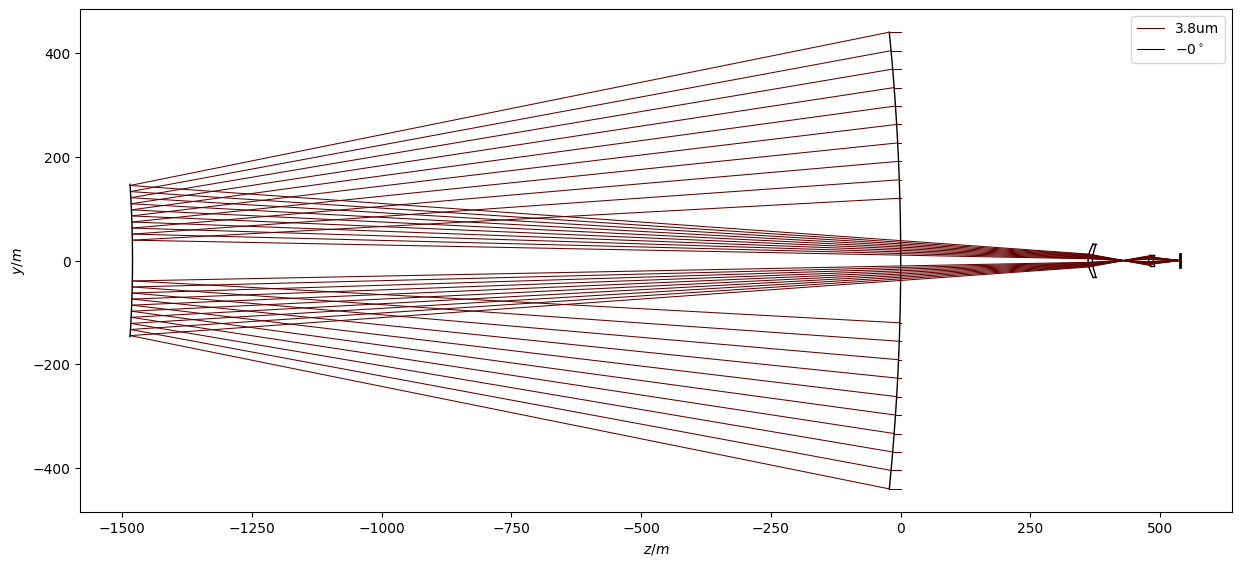

In [7]:
_ = o.plot_cross_section(height=0, wl=o.wl[1])

## 点扩散函数

In [8]:
def vis_psf(psf, segments, vis_size):
    segments = (segments[0] + 1) // 2, (segments[1] + 1) // 2
    psf_max = psf.max()
    psf_vis = (psf / psf_max)
    fig, axs = plt.subplots(*segments, figsize=(12, 9))
    for i in range(segments[0]):
        for j in range(segments[1]):
            ax = axs[i, j]
            psf_seg = dnois.utils.resize(psf_vis[i, j], vis_size)
            if psf_seg.ndim == 3:
                psf_seg = psf_seg.permute(1, 2, 0)
            ax.imshow(psf_seg.cpu().numpy(), vmin=0, vmax=1)
            ax.set(xticks=[], yticks=[])

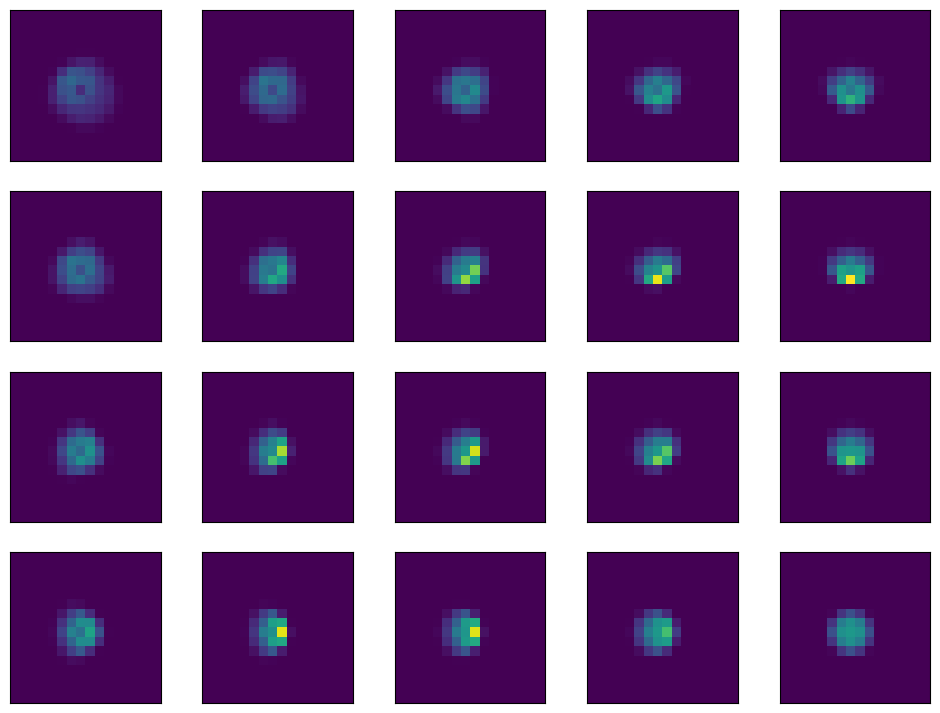

In [10]:
points = o.points_grid((7, 9), o.depth.squeeze().item())[:4, :5]
psf = o.psf(points, wl=o.wl[1])  #(NH, NW, Nwl, H, W)
vis_psf(psf, (7, 9), 16)

## 成像模拟

In [11]:
image = torchvision.io.read_image('asset/test.jpg')
image = image.to(device=dev, dtype=o.dtype) / 255
image = dnois.utils.resize(image, o.sensor.resolution)
image = image.unsqueeze(0)
pred, captured = framework(image)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 125 but got size 124 for tensor number 1 in the list.

Text(0.5, 1.0, 'Restored')

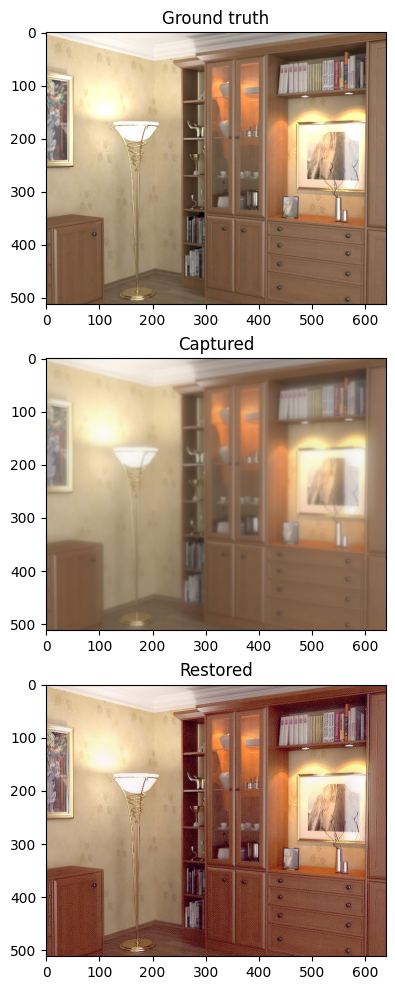

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(6, 12))
axs[0].imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
axs[0].set_title('Ground truth')
axs[1].imshow(captured.squeeze(0).permute(1, 2, 0).cpu().numpy())
axs[1].set_title('Captured')
axs[2].imshow(pred.squeeze(0).permute(1, 2, 0).cpu().numpy())
axs[2].set_title('Restored')

# 文件导出

In [ ]:
o.surfaces.save_json('structure/exported.json')